# music tagging

## Config

In [1]:
!pip install -q numpy
!pip install -q librosa
!pip install -q matplotlib
!pip install -q scikit-learn

## set random

In [2]:
import os
import keras
import numpy as np

SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

## create an example spectrogram

In [3]:
AUDIO_FILE = './test.mp3'

In [4]:
#music link: https://ncs.io/BurningWish
!wget -O test.mp3 https://ncs.io/track/download/537daa22-de4e-454f-8df2-33f60b107129

--2024-02-03 20:07:38--  https://ncs.io/track/download/537daa22-de4e-454f-8df2-33f60b107129
Resolving ncs.io (ncs.io)... 161.35.167.236
Connecting to ncs.io (ncs.io)|161.35.167.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6145089 (5.9M) [audio/mpeg]
Saving to: ‘test.mp3’

test.mp3            100%[===================>]   5.86M  5.39MB/s    in 1.1s    

2024-02-03 20:07:40 (5.39 MB/s) - ‘test.mp3’ saved [6145089/6145089]



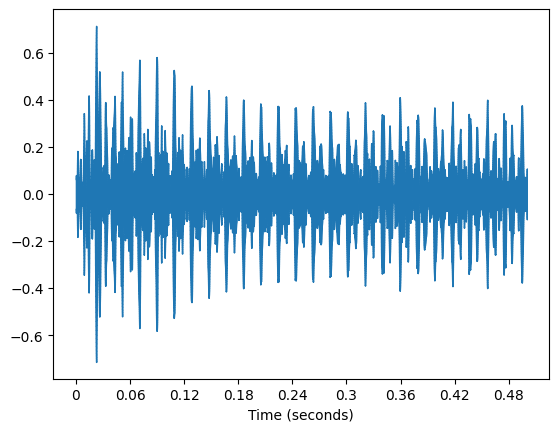

In [5]:
import librosa

samples, sample_rate = librosa.load(AUDIO_FILE, sr=None, duration=.5)

librosa.display.waveshow(samples, sr=sample_rate, axis='s')

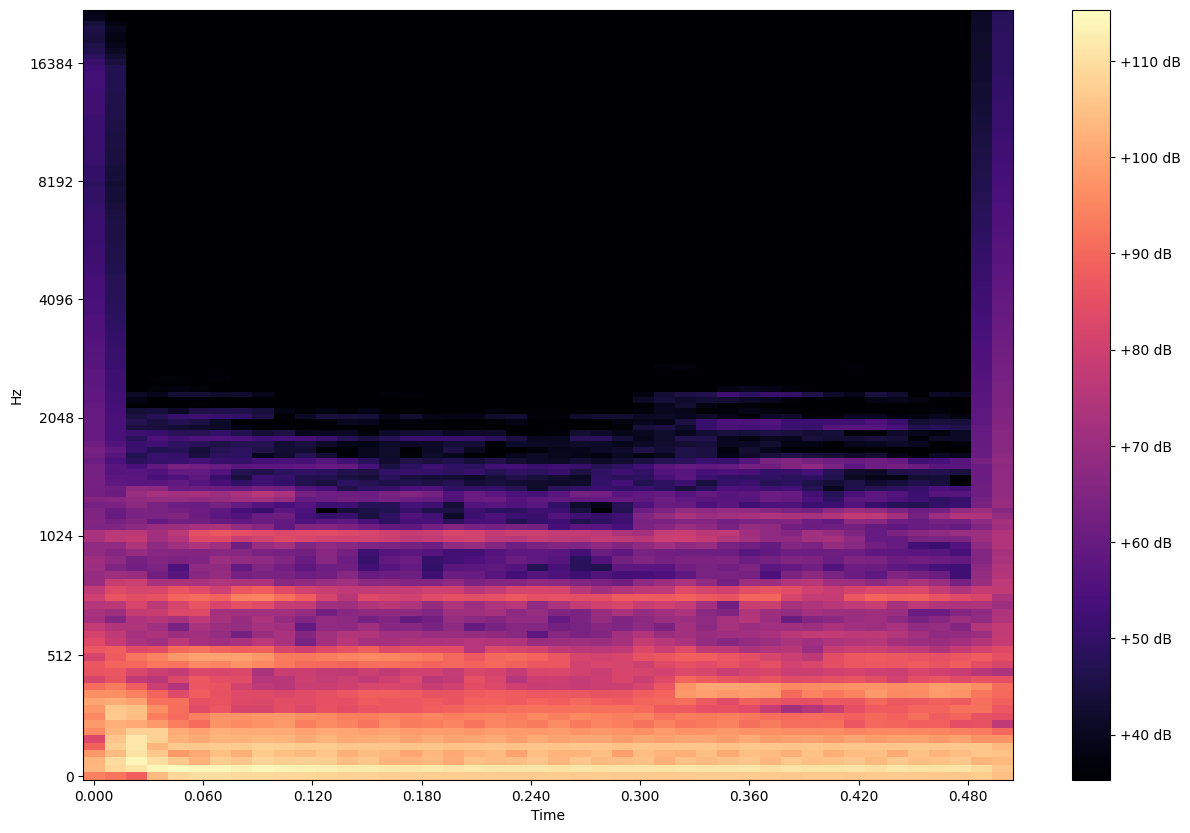

In [6]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

sgram = librosa.stft(samples)
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [7]:
type(mel_sgram)

numpy.ndarray

## Data

### Constants

In [8]:
TAR_LIST = "./mtg-jamendo-dataset/data/download/autotagging_moodtheme_melspecs_sha256_tars.txt"
COUNT_OF_LINES = 5
TRACK_LIST = "./data/genre.tsv"
DATA_DIR = "./data"

### download script and gernes

In [9]:
!mkdir ./data

In [10]:
!wget -q -O ./data/genre.tsv https://raw.githubusercontent.com/MTG/mtg-jamendo-dataset/master/data/autotagging_genre.tsv

In [11]:
!mkdir -p ./mtg-jamendo-dataset/scripts/download/
!mkdir -p ./mtg-jamendo-dataset/data/download/

In [12]:
!wget -q -O ./mtg-jamendo-dataset/scripts/download/d.py https://github.com/MTG/mtg-jamendo-dataset/raw/master/scripts/download/download.py

In [13]:
!wget -q -O ./mtg-jamendo-dataset/data/download/autotagging_moodtheme_melspecs_sha256_tars.txt https://raw.githubusercontent.com/MTG/mtg-jamendo-dataset/master/data/download/autotagging_moodtheme_melspecs_sha256_tars.txt

In [14]:
def save_some_lines(file_path, count_of_lines):
  with open(file_path, 'r') as source_file:
    lines = source_file.readlines()

  saved_lines = lines[:count_of_lines]

  with open(file_path, 'w') as dest_file:
    for line in saved_lines:
      dest_file.write(line)

save_some_lines(TAR_LIST, COUNT_OF_LINES)

In [15]:
!wget -q -O ./mtg-jamendo-dataset/data/download/autotagging_moodtheme_melspecs_sha256_tracks.txt https://raw.githubusercontent.com/MTG/mtg-jamendo-dataset/master/data/download/autotagging_moodtheme_melspecs_sha256_tracks.txt

In [16]:
!python ./mtg-jamendo-dataset/scripts/download/d.py --dataset autotagging_moodtheme --type melspecs ./data --unpack --remove > log.txt

Downloading...
From: https://cdn.freesound.org/mtg-jamendo/autotagging_moodtheme/melspecs/autotagging_moodtheme_melspecs-00.tar
To: data/autotagging_moodtheme_melspecs-00.tar
100% 767M/767M [00:41<00:00, 18.3MB/s]
Downloading...
From: https://cdn.freesound.org/mtg-jamendo/autotagging_moodtheme/melspecs/autotagging_moodtheme_melspecs-01.tar
To: data/autotagging_moodtheme_melspecs-01.tar
100% 750M/750M [00:40<00:00, 18.3MB/s]
Downloading...
From: https://cdn.freesound.org/mtg-jamendo/autotagging_moodtheme/melspecs/autotagging_moodtheme_melspecs-02.tar
To: data/autotagging_moodtheme_melspecs-02.tar
100% 804M/804M [00:43<00:00, 18.4MB/s]
Downloading...
From: https://cdn.freesound.org/mtg-jamendo/autotagging_moodtheme/melspecs/autotagging_moodtheme_melspecs-03.tar
To: data/autotagging_moodtheme_melspecs-03.tar
100% 707M/707M [00:38<00:00, 18.5MB/s]
Downloading...
From: https://cdn.freesound.org/mtg-jamendo/autotagging_moodtheme/melspecs/autotagging_moodtheme_melspecs-04.tar
To: data/autotag

### validate data in .tsv

In [17]:
def convert_path(s):
  numbers = s.replace('.mp3', '').split('/')
  return numbers

In [18]:
def remove_prefix_from_tag(tag):
  return tag.removeprefix("genre---")

In [19]:
def process_row(row):
  row = dict(row)
  row['TAGS'] = [row['TAGS']]
  if None in row:
    row['TAGS'].extend(row[None])
    del row[None]

  del row['TRACK_ID']
  del row['ARTIST_ID']
  del row['ALBUM_ID']
  del row['DURATION']

  row['PATH'] = convert_path(row['PATH'])
  row['TAGS'] = [remove_prefix_from_tag(tag) for tag in row['TAGS']]
  return row

In [20]:
import csv

def filter_dataset(tsvfile_path, row_filter, row_procces, fieldnames):
  with open(tsvfile_path, 'r') as tsvfile:
    reader = csv.DictReader(tsvfile, delimiter='\t')
    filtered_rows = [row_procces(row) for row in reader if row_filter(row)]

  with open(tsvfile_path, 'w') as tsvfile:
    writer = csv.DictWriter(tsvfile, fieldnames=fieldnames, delimiter='\t')
    writer.writeheader()
    writer.writerows(filtered_rows)

In [21]:
tar_filter = lambda row: int(row['PATH'].split('/')[0]) in range(0, COUNT_OF_LINES)
filter_dataset(TRACK_LIST, tar_filter, process_row, ['PATH', 'TAGS'])

In [22]:
import os

def get_all_dat(data_dir, file_extension):
  data = []
  for root, dirs, files in os.walk(data_dir):
    if root == data_dir:
      continue
    for file in files:
      file = file.removesuffix(file_extension)
      data.append([os.path.basename(root), file])
    return data

data = get_all_dat(DATA_DIR, '.npy')

In [23]:
import ast

loaded_data_filter = lambda row: ast.literal_eval(row['PATH']) in data
processor = lambda row: row

filter_dataset(TRACK_LIST, loaded_data_filter, processor, ['PATH', 'TAGS'])

In [24]:
import csv

def get_different_genres(tracks_file):
  different_genres = set()

  with open(tracks_file, 'r') as tsvfile:
    reader = csv.DictReader(tsvfile, delimiter='\t')
    for row in reader:
      tags = row['TAGS']
      different_genres.update(tags)

  return list(different_genres)

different_genres = get_different_genres(TRACK_LIST)

### unify and normalize data

In [25]:
import numpy as np
import sys

def find_min_max_maxshape(data_names, data_dir):
  min_v = sys.maxsize
  max_v = -sys.maxsize - 1
  max_shape = (0, 0)

  for name in data_names:
    spectrogram = np.load(f"{data_dir}/{name[0]}/{name[1]}.npy")
    loc_min = np.min(spectrogram)
    loc_max = np.max(spectrogram)
    min_v = min(min_v,loc_min)
    max_v = max(max_v,loc_max)
    max_shape = max(max_shape, spectrogram.shape, key=lambda x: x[0]*x[1])

  return min_v, max_v, max_shape

In [26]:
def normalize_data(min_v, max_v, data_names, data_dir):
  for name in data_names:
    path = f"{data_dir}/{name[0]}/{name[1]}.npy"
    spectrogram = np.load(path)
    spectrogram = (spectrogram - min_v) / (max_v - min_v)
    np.save(path, spectrogram)

In [27]:
def unify_data(max_shape, new_shape, data_names, data_dir):
  for name in data_names:
    path = f"{data_dir}/{name[0]}/{name[1]}.npy"
    spectrogram = np.load(path)
    padded = np.pad(spectrogram, ((0, 0), (0, max_shape[1] - spectrogram.shape[1])))
    new_shaped = padded.reshape(new_shape)
    np.save(path, new_shaped)

In [28]:
import math

def get_3d_shape(shape_2d):
  number = shape_2d[1]
  first = int(math.sqrt(number))
  while number % first != 0:
      first -= 1
  second = number // first

  return shape_2d[0], first, second

In [29]:
min_v, max_v, max_shape = find_min_max_maxshape(data, DATA_DIR)
new_shape = get_3d_shape(max_shape)

normalize_data(min_v, max_v, data, DATA_DIR)
unify_data(max_shape, new_shape, data, DATA_DIR)

### split data

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import ast

data_file_names = []
genres = []

with open(TRACK_LIST, 'r') as tsvfile:
  reader = csv.DictReader(tsvfile, delimiter='\t')
  for row in reader:
    data_file_names.append(ast.literal_eval(row["PATH"]))
    genres.append(row["TAGS"])

binarizer = MultiLabelBinarizer(classes=different_genres)
one_hot_genres = binarizer.fit_transform(genres)

one_hot_genres = np.array(one_hot_genres)
data_file_names = np.array(data_file_names)

In [31]:
from sklearn.model_selection import train_test_split

names_train, names_test, y_train, y_test = train_test_split(data_file_names, one_hot_genres, test_size=0.1, random_state=SEED)

### DataLoader

In [32]:
import numpy as np

class NpyGenerator(keras.utils.Sequence):
  def __init__(self, data_dir, labels, data_file_names, batch_size=32):
    self.data_dir = data_dir
    self.labels = labels
    self.batch_size = batch_size
    self.data_file_names = data_file_names


  def __len__(self):
    return int(np.ceil(len(self.labels) / float(self.batch_size)))


  def __shuffle(self):
    labels = self.labels
    names = self.data_file_names
    indices = np.random.permutation(len(labels))

    self.labels = labels[indices]
    self.data_file_names = names[indices]


  def __get_spectrograms(self, names):
    batch_data = []
    path = self.data_dir
    for name in names:
      spectrogram = np.load(f"{path}/{name[0]}/{name[1]}.npy")
      batch_data.append(spectrogram)

    return np.array(batch_data)


  def __getitem__(self, idx):
    if idx == 0:
      self.__shuffle()

    batch_start = idx * self.batch_size
    batch_end = (idx + 1) * self.batch_size

    batch_labels = self.labels[batch_start:batch_end]
    batch_names = self.data_file_names[batch_start:batch_end]

    batch_data = self.__get_spectrograms(batch_names)

    return batch_data, batch_labels

## Model

### inputs and outputs

In [33]:
input_shape = new_shape
num_of_classes = len(different_genres)

### data generator

In [34]:
train_generator = NpyGenerator(DATA_DIR, y_train, names_train, 32)
test_generator = NpyGenerator(DATA_DIR, y_test, names_test, 32)

### Create Model

In [35]:
model = keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,
    input_shape=input_shape,
)

model.trainable = True

/usr/local/lib/python3.10/dist-packages/keras/src/applications/efficientnet.py:321: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 211 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [36]:
inputs = keras.Input(shape=input_shape)

x = model(inputs)
x = keras.layers.GlobalAveragePooling2D()(x) # model output is 4d

outputs = keras.layers.Dense(num_of_classes, activation=keras.activations.sigmoid)(x)
model = keras.Model(inputs, outputs)

### find optimal lr

In [37]:
import keras
import matplotlib.pyplot as plt

def optimal_lr(datagenerator, model):
  lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch/20))
  model.compile(
      loss=keras.losses.BinaryCrossentropy(from_logits=False),
      optimizer=keras.optimizers.Adam(1e-5),
  )

  history = model.fit(
      datagenerator,
      steps_per_epoch=1,
      epochs=60,
      callbacks=[lr_scheduler],
  )

  lrs = 1e-5 * (10 ** (np.arange(60)/20))
  plt.figure(figsize=(10, 10))
  plt.semilogx(lrs, history.history["loss"])
  plt.xlabel("Learning Rate")
  plt.ylabel("Loss")
  plt.title("Learning rate vs. loss");
  plt.show()

Epoch 1/60
1/1 [==============================] - 43s 43s/step - loss: 0.7124 - lr: 1.0000e-05
Epoch 2/60
1/1 [==============================] - 2s 2s/step - loss: 0.7148 - lr: 1.1220e-05
Epoch 3/60
1/1 [==============================] - 1s 1s/step - loss: 0.7174 - lr: 1.2589e-05
Epoch 4/60
1/1 [==============================] - 1s 1s/step - loss: 0.7180 - lr: 1.4125e-05
Epoch 5/60
1/1 [==============================] - 1s 1s/step - loss: 0.7191 - lr: 1.5849e-05
Epoch 6/60
1/1 [==============================] - 1s 1s/step - loss: 0.7243 - lr: 1.7783e-05
Epoch 7/60
1/1 [==============================] - 1s 691ms/step - loss: 0.7224 - lr: 1.9953e-05
Epoch 8/60
1/1 [==============================] - 1s 1s/step - loss: 0.7022 - lr: 2.2387e-05
Epoch 9/60
1/1 [==============================] - 1s 1s/step - loss: 0.7183 - lr: 2.5119e-05
Epoch 10/60
1/1 [==============================] - 1s 1s/step - loss: 0.7048 - lr: 2.8184e-05
Epoch 11/60
1/1 [==============================] - 1s 1s/step - 

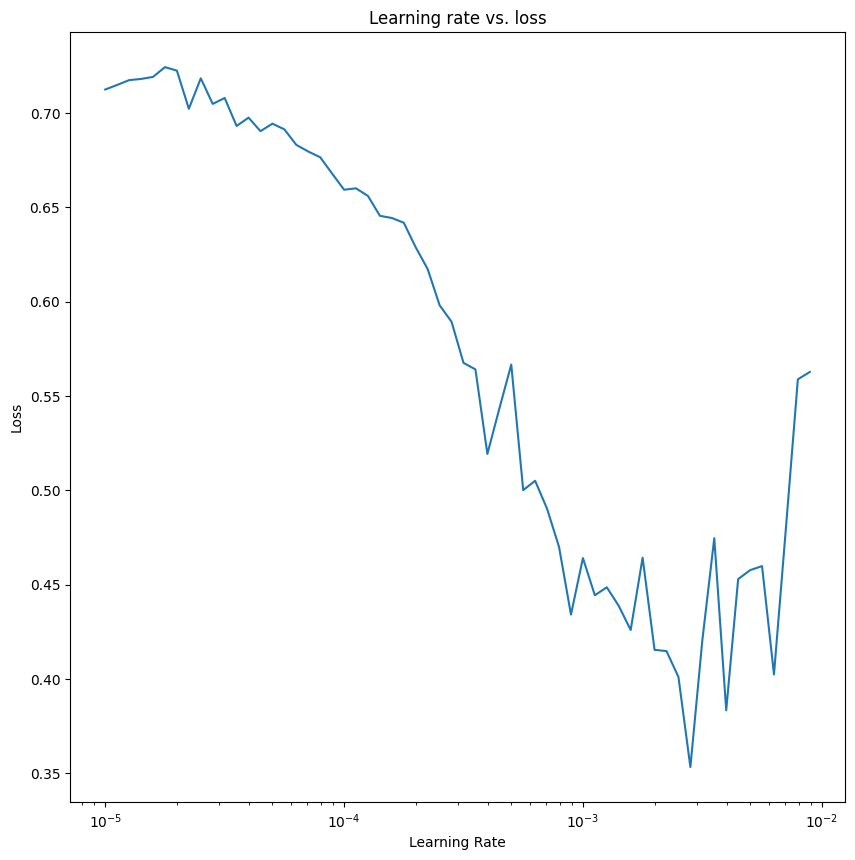

In [38]:
optimal_lr(train_generator, model)

### Train

In [39]:
LR = 10**-3.65
early_stopping = keras.callbacks.EarlyStopping(monitor='binary_accuracy', patience=3)

In [40]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(LR),
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [41]:
model.fit(
    train_generator,
    epochs=50,
    callbacks=[early_stopping],
)

Epoch 1/50
6/6 [==============================] - 36s 621ms/step - loss: 0.4629 - binary_accuracy: 0.7934
Epoch 2/50
6/6 [==============================] - 5s 744ms/step - loss: 0.4180 - binary_accuracy: 0.8119
Epoch 3/50
6/6 [==============================] - 5s 742ms/step - loss: 0.3980 - binary_accuracy: 0.8172
Epoch 4/50
6/6 [==============================] - 5s 740ms/step - loss: 0.3911 - binary_accuracy: 0.8179
Epoch 5/50
6/6 [==============================] - 5s 960ms/step - loss: 0.3845 - binary_accuracy: 0.8206
Epoch 6/50
6/6 [==============================] - 5s 727ms/step - loss: 0.3671 - binary_accuracy: 0.8323
Epoch 7/50
6/6 [==============================] - 5s 754ms/step - loss: 0.3743 - binary_accuracy: 0.8282
Epoch 8/50
6/6 [==============================] - 5s 734ms/step - loss: 0.3644 - binary_accuracy: 0.8257
Epoch 9/50
6/6 [==============================] - 5s 713ms/step - loss: 0.3449 - binary_accuracy: 0.8435
Epoch 10/50
6/6 [==============================] - 5s 

### Test

In [42]:
test_loss, test_acc = model.evaluate(test_generator)

1/1 [==============================] - 3s 3s/step - loss: 0.4682 - binary_accuracy: 0.7624


In [43]:
print(f'Test loss:{test_loss} \t Test accuracy:{test_acc}')

Test loss:0.46818411350250244 	 Test accuracy:0.7624059915542603
